In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
DATA_DIR = "/home/jarvis/ML/asl-alphabet"
TRAIN_DIR = os.path.join(DATA_DIR,"asl_alphabet_train")
TEST_DIR = "asl_alphabet_test"
Category = [chr(x) for x in range(ord('A'),ord('Z')+1)]
Category.append('del')
Category.append('nothing')
Category.append('space')

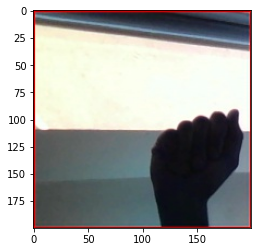

In [3]:
for category in Category:
    path = os.path.join(TRAIN_DIR,category)
    for img in os.listdir(path):
        image = cv2.imread(os.path.join(path,img))
        plt.imshow(image)
        plt.show()
        break
    break
    


In [4]:
print(image.shape)

(200, 200, 3)


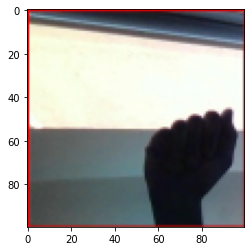

In [5]:
IMG_SIZE = 100
new_image = cv2.resize(image,(IMG_SIZE,IMG_SIZE))
plt.imshow(new_image)
plt.show()

In [8]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
BATCH_SIZE = 64

train_data = image_dataset_from_directory(
    directory = TRAIN_DIR,
    labels = 'inferred',
    label_mode = 'categorical',
    color_mode = 'rgb',
    batch_size = BATCH_SIZE,
    image_size = (IMG_SIZE,IMG_SIZE),
    shuffle = True,
    seed = 1,
    validation_split = 0.3,
    subset = 'training'
)


Found 87000 files belonging to 29 classes.
Using 60900 files for training.


In [9]:
val_data = image_dataset_from_directory(
    directory = TRAIN_DIR,
    labels = 'inferred',
    label_mode = 'categorical',
    color_mode = 'rgb',
    batch_size = BATCH_SIZE,
    image_size = (IMG_SIZE,IMG_SIZE),
    shuffle = True,
    seed = 1,
    validation_split = 0.3,
    subset = 'validation'
)

Found 87000 files belonging to 29 classes.
Using 26100 files for validation.


In [13]:
print(train_data)

<BatchDataset shapes: ((None, 100, 100, 3), (None, 29)), types: (tf.float32, tf.float32)>


In [15]:
def normalize_image(image,label):
    image = (image/127.5)-1
    return (image,label)
train_data = train_data.map(normalize_image)
val_data = val_data.map(normalize_image)

In [16]:
for image_batch,label_batch in train_data.take(1):
    pass
print(image_batch.shape)

(64, 100, 100, 3)


In [18]:
import tensorflow as tf
IMG_SHAPE = (IMG_SIZE,IMG_SIZE,3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top = False,
                                              weights = 'imagenet')
feature_batch = base_model(image_batch)
print(feature_batch.shape)

9412608/9406464 [==============================] - 5s 1us/step
(64, 4, 4, 1280)


In [19]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 101, 101, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 50, 50, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 50, 50, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [21]:
global_average_layer = tf.keras.layers.GlobalMaxPooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(64, 1280)


In [22]:
prediction_layer = tf.keras.layers.Dense(29,activation = 'softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(64, 29)


In [26]:
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])
base_learning_rate = 0.0001
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 29)                37149     
Total params: 2,295,133
Trainable params: 37,149
Non-trainable params: 2,257,984
_________________________________________________________________


In [30]:
initial_epochs = 10
validation_steps=20

loss0,accuracy0 = model.evaluate(val_data, steps = validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

20/20 [==============================] - 7s 326ms/step - loss: 0.6248 - accuracy: 0.8000
initial loss: 0.62
initial accuracy: 0.80


In [31]:
history = model.fit(train_data,
                    epochs=10,
                    validation_data=val_data)

Epoch 1/10
952/952 [==============================] - 1438s 2s/step - loss: 0.2499 - accuracy: 0.9231 - val_loss: 0.1735 - val_accuracy: 0.9428
Epoch 2/10
952/952 [==============================] - 454s 476ms/step - loss: 0.0958 - accuracy: 0.9708 - val_loss: 0.0754 - val_accuracy: 0.9775
Epoch 3/10
952/952 [==============================] - 500s 525ms/step - loss: 0.0594 - accuracy: 0.9822 - val_loss: 0.0562 - val_accuracy: 0.9830
Epoch 4/10
952/952 [==============================] - 500s 526ms/step - loss: 0.0484 - accuracy: 0.9852 - val_loss: 0.0429 - val_accuracy: 0.9857
Epoch 5/10
952/952 [==============================] - 507s 533ms/step - loss: 0.0492 - accuracy: 0.9846 - val_loss: 0.0623 - val_accuracy: 0.9790
Epoch 6/10
952/952 [==============================] - 527s 554ms/step - loss: 0.0456 - accuracy: 0.9849 - val_loss: 0.0438 - val_accuracy: 0.9848
Epoch 7/10
952/952 [==============================] - 520s 546ms/step - loss: 0.0346 - accuracy: 0.9886 - val_loss: 0.0486 - v

In [32]:
model.save('mobnet.h5')